# Импорт библиотек

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
from scipy.stats import zscore

# Загрузка датасета

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv

--2025-01-23 00:40:14--  https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/csv]
Saving to: ‘Mall_Customers.csv.1’

Mall_Customers.csv. 100%[===================>]   3.89K  --.-KB/s    in 0s      

2025-01-23 00:40:15 (1021 MB/s) - ‘Mall_Customers.csv.1’ saved [3981/3981]



In [ ]:
# Загрузка данных
df = pd.read_csv('Mall_Customers.csv')

In [ ]:
print(df.head(10))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72


In [ ]:
# Выбор трёх признаков
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
X = df[features]

In [ ]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Применение K-Means
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

In [ ]:
# Добавление меток кластеров в DataFrame
df["Cluster"] = labels

In [ ]:
import plotly.express as px

# Построение интерактивного 3D-графика
fig = px.scatter_3d(
    df,
    x="Age",
    y="Annual Income (k$)",
    z="Spending Score (1-100)",
    color="Cluster",
    title="Сегментация клиентов (Интерактивный 3D-график)",
    labels={"Cluster": "Кластер"},
    opacity=1
)

# Настройки графика
fig.update_traces(marker=dict(size=5))  # Устанавливаем размер маркеров
fig.update_layout(
    scene=dict(
        xaxis_title="Age",
        yaxis_title="Annual Income (k$)",
        zaxis_title="Spending Score (1-100)"
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Показ графика
fig.show()

# Сравнение стабильности K-means и K-means++

In [ ]:
# Функция для оценки стабильности
def evaluate_kmeans(X, n_clusters=6, iterations=10):
    results = {"standard_kmeans": [], "kmeans++": []}

    for random_state in range(iterations):
        # Стандартный K-Means (инициализация "random")
        kmeans_standard = KMeans(
            n_clusters=n_clusters, init="random", n_init="auto", random_state=random_state
        )
        kmeans_standard.fit(X)
        inertia_standard = kmeans_standard.inertia_
        silhouette_standard = silhouette_score(X, kmeans_standard.labels_)
        results["standard_kmeans"].append((inertia_standard, silhouette_standard))

        # K-Means++ (инициализация "k-means++")
        kmeans_plus = KMeans(
            n_clusters=n_clusters, init="k-means++", n_init="auto", random_state=random_state
        )
        kmeans_plus.fit(X)
        inertia_plus = kmeans_plus.inertia_
        silhouette_plus = silhouette_score(X, kmeans_plus.labels_)
        results["kmeans++"].append((inertia_plus, silhouette_plus))

    return results

In [ ]:
# Выполнение оценок
results = evaluate_kmeans(X_scaled, n_clusters=6, iterations=10)

In [ ]:
# Средние результаты
standard_avg_inertia = np.mean([res[0] for res in results["standard_kmeans"]])
standard_avg_silhouette = np.mean([res[1] for res in results["standard_kmeans"]])
plus_avg_inertia = np.mean([res[0] for res in results["kmeans++"]])
plus_avg_silhouette = np.mean([res[1] for res in results["kmeans++"]])

In [ ]:
# Вывод результатов
print("Средние значения по 10 итерациям:")
print(f"Standard K-Means: Inertia = {standard_avg_inertia:.2f}, Silhouette = {standard_avg_silhouette:.2f}")
print(f"K-Means++: Inertia = {plus_avg_inertia:.2f}, Silhouette = {plus_avg_silhouette:.2f}")

# Сравнение разброса значений
standard_inertia_std = np.std([res[0] for res in results["standard_kmeans"]])
plus_inertia_std = np.std([res[0] for res in results["kmeans++"]])
print("\nРазброс значений (стандартное отклонение):")
print(f"Standard K-Means: Inertia std = {standard_inertia_std:.2f}")
print(f"K-Means++: Inertia std = {plus_inertia_std:.2f}")

Средние значения по 10 итерациям:
Standard K-Means: Inertia = 133.88, Silhouette = 0.43
K-Means++: Inertia = 145.96, Silhouette = 0.40

Разброс значений (стандартное отклонение):
Standard K-Means: Inertia std = 0.01
K-Means++: Inertia std = 10.17


Вывод:

K-Means демонстрирует низкий разброс инерции, что указывает на стабильность результата, однако низкая инерция и высокий силуэтный коэффициент могут быть связаны с попаданием в локальный минимум, а не с отражением реальной структуры данных.

K-Means++ имеет более высокий разброс инерции указывает на чувствительность метода к данным, однако это подтверждает, что метод исследует пространство данных более тщательно

# Удаление выбросов

In [ ]:
# Функция для удаления выбросов
def remove_outliers(data, z_threshold=1.75):    #значение z выбрано путём множества запусков
    """
    Удаляет выбросы на основе Z-оценок.
    Параметры:
        data (numpy array): стандартизированные данные
        z_threshold (float): порог для Z-оценок
    Возвращает:
        очищенные данные (numpy array)
    """
    z_scores = np.abs(zscore(data))
    filtered_data = data[(z_scores < z_threshold).all(axis=1)]
    return filtered_data

In [ ]:
# Удаление выбросов
X_cleaned = remove_outliers(X_scaled)

In [ ]:
# Кластеризация и оценка
def cluster_and_evaluate(data, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++", n_init="auto")
    kmeans.fit(data)
    inertia = kmeans.inertia_
    silhouette = silhouette_score(data, kmeans.labels_)
    return inertia, silhouette

In [ ]:
# Результаты до удаления выбросов
inertia_before, silhouette_before = cluster_and_evaluate(X_scaled)

# Результаты после удаления выбросов
inertia_after, silhouette_after = cluster_and_evaluate(X_cleaned)

# Вывод результатов
print("Результаты кластеризации:")
print(f"До удаления выбросов: Inertia = {inertia_before:.2f}, Silhouette = {silhouette_before:.2f}")
print(f"После удаления выбросов: Inertia = {inertia_after:.2f}, Silhouette = {silhouette_after:.2f}")

Результаты кластеризации:
До удаления выбросов: Inertia = 134.35, Silhouette = 0.43
После удаления выбросов: Inertia = 76.37, Silhouette = 0.46


In [ ]:
print(f"Исходное количество точек: {len(X_scaled)}")
print(f"Количество точек после удаления: {len(X_cleaned)}")

Исходное количество точек: 200
Количество точек после удаления: 165


In [ ]:
def visualize_data(data, title="Распределение данных"):
    plt.scatter(data[:, 0], data[:, 1], s=50, cmap="viridis")
    plt.title(title)
    plt.show()

<ipython-input-34-e35cbcb0919c>:2: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



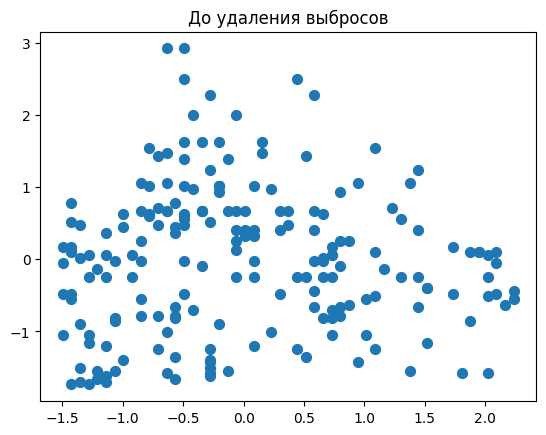

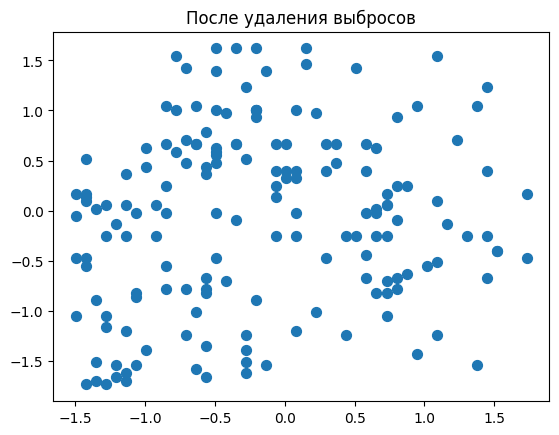

In [ ]:
visualize_data(X_scaled, title="До удаления выбросов")
visualize_data(X_cleaned, title="После удаления выбросов")

Вывод:

Удаление выбросов помогло сделать кластеры более компактными и различимыми

# Оценка кластеризации при значениях k от 2 до 8

In [ ]:
# Функция для вычисления и визуализации силуэтных коэффициентов
def silhouette_analysis(X, k_range):
    silhouette_avg_scores = []

    for k in k_range:
        # Кластеризация K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", n_init="auto")
        labels = kmeans.fit_predict(X)

        # Силуэтный коэффициент
        silhouette_avg = silhouette_score(X, labels)
        silhouette_avg_scores.append(silhouette_avg)

        # Визуализация силуэтных коэффициентов для текущего k
        sample_silhouette_values = silhouette_samples(X, labels)
        fig, ax = plt.subplots(figsize=(10, 6))

        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                alpha=0.7,
            )
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # Отступ для следующего кластера

        ax.set_title(f"Силуэтный анализ для k={k}", fontsize=14)
        ax.set_xlabel("Силуэтный коэффициент")
        ax.set_ylabel("Индекс кластера")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        plt.show()
        print("\n")


    # Построение графика средней силуэтной оценки
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, silhouette_avg_scores, marker="o", linestyle="--")
    plt.title("Средний силуэтный коэффициент для различных k", fontsize=14)
    plt.xlabel("Количество кластеров (k)")
    plt.ylabel("Средний силуэтный коэффициент")
    plt.grid()
    plt.show()

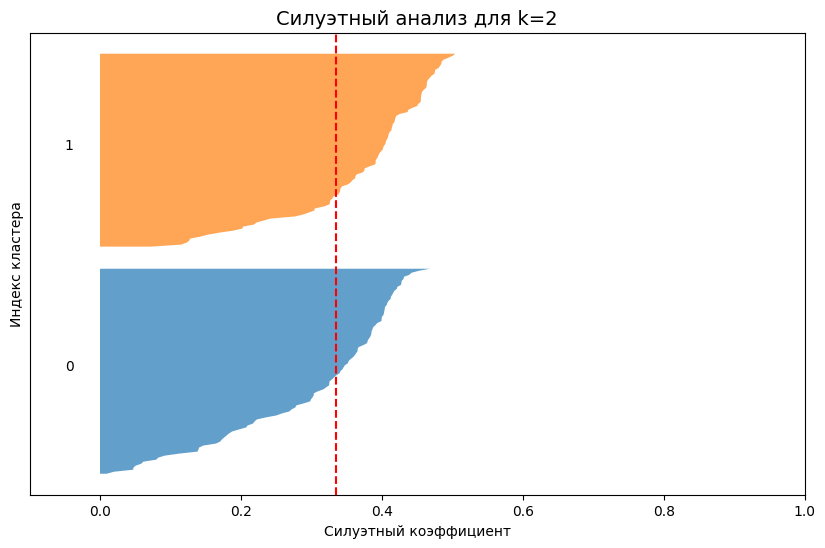

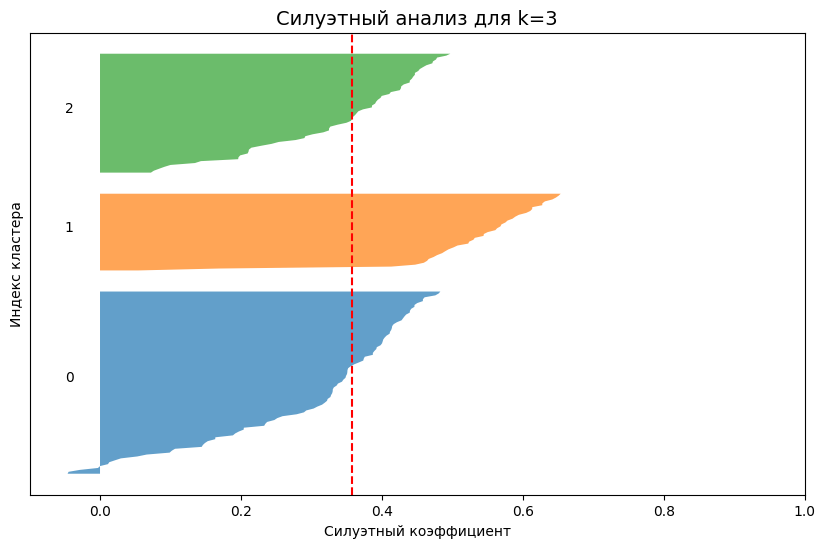

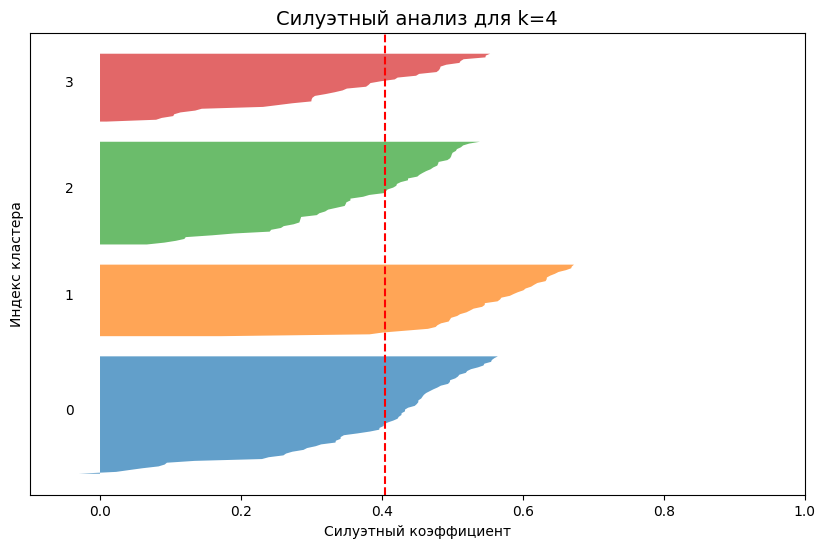

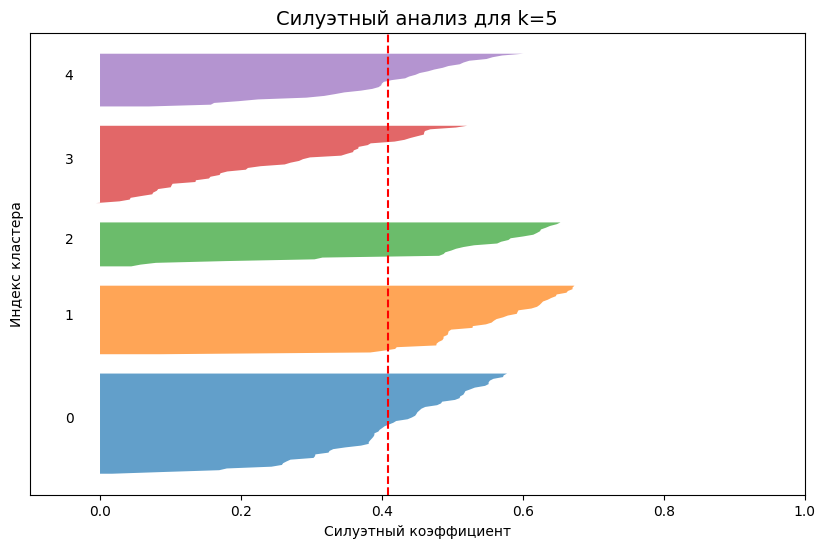

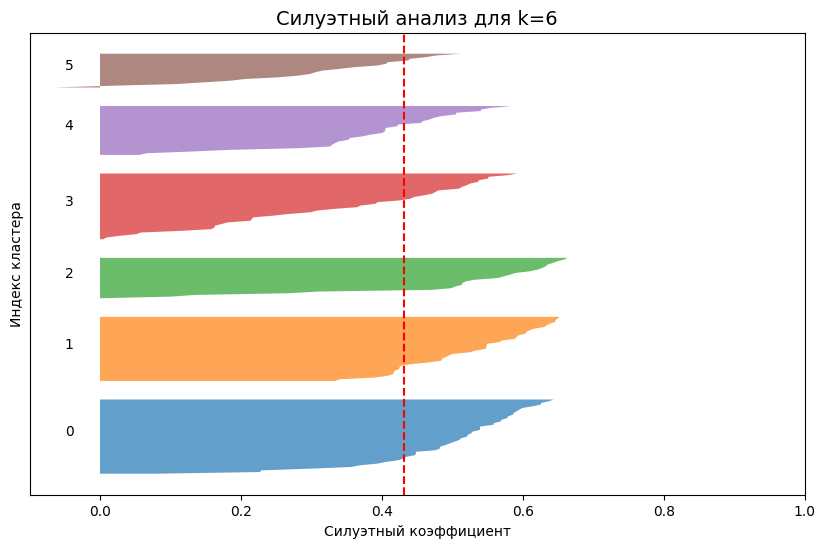

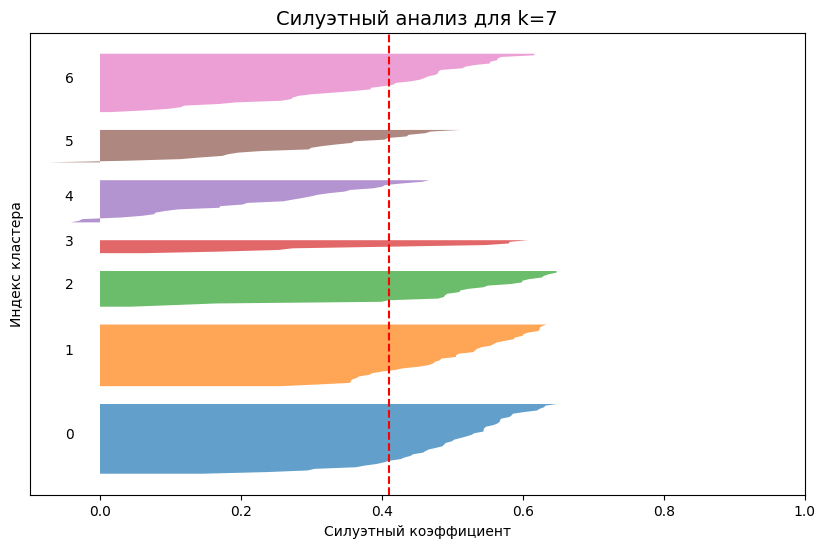

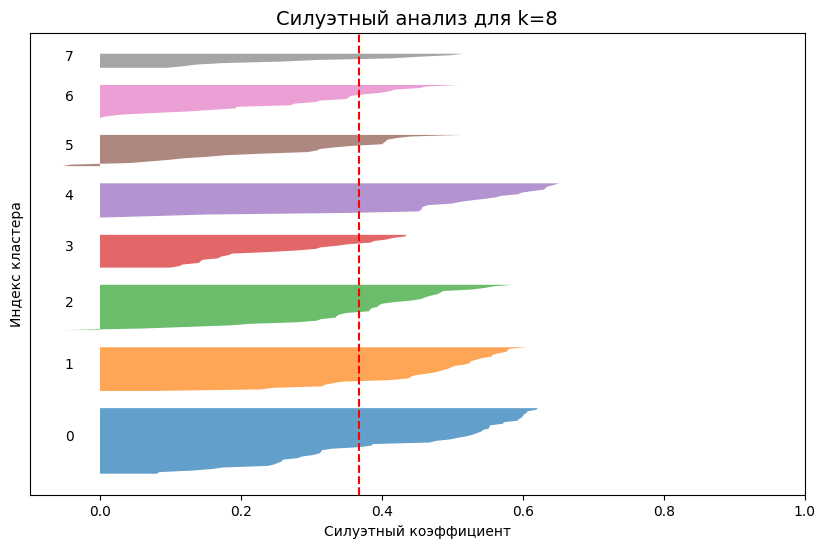

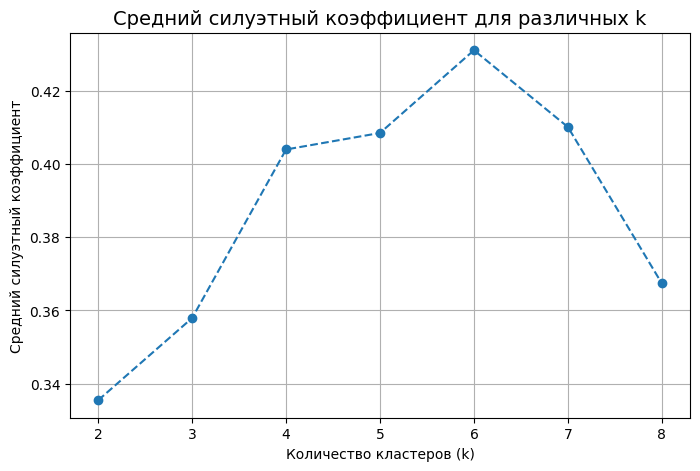

In [ ]:
# Выполнение силуэтного анализа
k_range = range(2, 9)
silhouette_analysis(X_scaled, k_range)

Вывод:

Значение k=6 показывает наибольший силуэтный коэфициент

# Создание нового признака, сравнение с ним и без него

In [ ]:
# Создание нового признака
df["Spending Ratio"] = df["Spending Score (1-100)"] / df["Annual Income (k$)"]

In [ ]:
# Базовая модель (только исходные признаки)
X_base = df[features]

# Расширенная модель (с новым признаком)
X_extended = df[features + ["Spending Ratio"]]

In [ ]:
# Стандартизация данных
scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)
X_extended_scaled = scaler.fit_transform(X_extended)

In [ ]:
# Кластеризация и оценка
def cluster_and_evaluate(data, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++", n_init="auto")
    kmeans.fit(data)
    inertia = kmeans.inertia_
    silhouette = silhouette_score(data, kmeans.labels_)
    return inertia, silhouette

In [ ]:
# Базовая модель
inertia_base, silhouette_base = cluster_and_evaluate(X_base_scaled)

# Расширенная модель
inertia_extended, silhouette_extended = cluster_and_evaluate(X_extended_scaled)

# Вывод результатов
print("Результаты кластеризации:")
print(f"Базовая модель: Inertia = {inertia_base:.2f}, Silhouette = {silhouette_base:.2f}")
print(f"Расширенная модель: Inertia = {inertia_extended:.2f}, Silhouette = {silhouette_extended:.2f}")

Результаты кластеризации:
Базовая модель: Inertia = 134.35, Silhouette = 0.43
Расширенная модель: Inertia = 184.89, Silhouette = 0.41


Вывод:

Добавление нового признака ухудшило результаты, вероятно, из-за высокой корреляции или доминирующего влияния нового признака